## gasification H2/CO _ 2 bins 50/50 _ lr = 1e-3 _ 100 epochs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Collection, Dict, List, Optional, Tuple, Union
from numpy.typing import ArrayLike
from fastcore.all import L
import pycm

In [3]:
def evaluate_classification(
    y_true: ArrayLike,
    y_pred: ArrayLike,
) -> Dict[str, Any]:
    """Evaluate a classification task.

    Args:
        y_true (ArrayLike): The true labels.
        y_pred (ArrayLike): The predicted labels.

    Returns:
        Dict[str, Any]: A dictionary of metrics.
    """
    might_have_rounded_floats = False
    assert len(y_true) == len(y_pred), "y_true and y_pred must be the same length."
    y_true = L([int(x) for x in y_true])

    y_pred_new = []
    int_indices = []
    for i, x in enumerate(y_pred):
        try:
            x_int = int(x)
            if x_int != x:
                might_have_rounded_floats = True
                logger.warning("y_pred contains rounded floats.")
            y_pred_new.append(x_int)
            int_indices.append(i)
        except Exception as e:
            y_pred_new.append(None)
    y_pred_new = L(y_pred_new)

    frac_valid = len(int_indices) / len(y_true)
    if len(int_indices) == 0:
        logger.warning("No valid predictions found.")
        y_pred_valid = L([None] * len(y_true))
        y_true_valid = y_true

    else:
        y_true_valid = y_true[int_indices]
        y_pred_valid = y_pred_new[int_indices]

    cm = pycm.ConfusionMatrix(list(y_true_valid), list(y_pred_valid))
    return {
        "accuracy": cm.Overall_ACC,
        "acc_macro": cm.ACC_Macro,
        "racc": cm.Overall_RACC,
        "kappa": cm.Kappa,
        "confusion_matrix": cm,
        "f1_macro": cm.F1_Macro,
        "f1_micro": cm.F1_Micro,
        "frac_valid": frac_valid,
        "all_y_true": y_true,
        "all_y_pred": y_pred,
        "valid_indices": int_indices,
        "might_have_rounded_floats": might_have_rounded_floats,
    }

In [4]:
from glob import glob
from fastcore.xtras import load_pickle
import os 
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt 
import matplotlib as mpl
#import seaborn as sns
import numpy as np 

from scipy.stats import sem
from scipy.constants import golden
ONE_COL_WIDTH_INCH = 3.25
TWO_COL_WIDTH_INCH = 7.2

ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

import sys

sys.path.append("../plotutils/")
from plotutils import *

plt.style.use("../plotutils/your.mplstyle")

import matplotx

In [5]:
all_res = glob(f"./*.pkl")
print(f"Pickles found: {len(all_res)}")

Pickles found: 85


### ADJUST dictionary according to experiment

In [6]:
compiled_res_list = []
conf_mats = []

for res in all_res:
    res = load_pickle(res)
    nan_prediction_mask = np.isnan(res["predictions"])
    try:
        results = evaluate_classification(res["targets"], res["predictions"][~nan_prediction_mask])
    except:
        results = evaluate_classification(res["true"], res["predictions"][~nan_prediction_mask])
    summary = {
        'train_size': res['train_size'],
        'accuracy': results['accuracy'],
        'acc_macro': results['acc_macro'],
        'racc': results['racc'],
        'kappa': results['kappa'],
        'f1_macro': results['f1_macro'],
        'f1_micro': results['f1_micro'],
        'frac_valid': results['frac_valid'],
        'valid_indices': results['valid_indices'],
        'might_have_rounded_floats': results['might_have_rounded_floats'],
    }
    
    confusion_matrix = {
        'all_y_true': results['all_y_true'],
        'all_y_pred': results['all_y_pred']
    }
    
    conf_mats.append(confusion_matrix)
    compiled_res_list.append(summary)

In [7]:
compiled_res = pd.DataFrame(compiled_res_list)

In [8]:
compiled_res = compiled_res.iloc[:, 0:8]
compiled_res

,train_size,accuracy,acc_macro,racc,kappa,f1_macro,f1_micro,frac_valid
0,5,0.577778,0.577778,0.491852,0.169096,0.516676,0.577778,1.0
1,10,0.550000,0.550000,0.500000,0.100000,0.550000,0.550000,1.0
2,15,0.771429,0.771429,0.500408,0.542484,0.771242,0.771429,1.0
3,20,0.733333,0.733333,0.500000,0.466667,0.732143,0.733333,1.0
4,25,0.760000,0.760000,0.500800,0.519231,0.759615,0.760000,1.0
...,...,...,...,...,...,...,...,...
80,45,1.000000,1.000000,0.520000,1.000000,1.000000,1.000000,1.0
81,25,0.800000,0.800000,0.499200,0.600639,0.800000,0.800000,1.0
82,30,0.750000,0.750000,0.500000,0.500000,0.744246,0.750000,1.0
83,40,0.700000,0.700000,0.500000,0.400000,0.670330,0.700000,1.0


### ADJUST columns according to grouping

In [9]:
grouped_res = compiled_res.groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy           acc_macro                racc            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
5           0.566667  0.018812  0.566667  0.018812  0.495556  0.001428   
10          0.595000  0.031136  0.595000  0.031136  0.500000  0.000000   
15          0.680000  0.030949  0.680000  0.030949  0.499918  0.000990   
20          0.650000  0.021228  0.650000  0.021228  0.500000  0.000000   
25          0.755556  0.012373  0.755556  0.012373  0.500622  0.000902   
30          0.710000  0.027689  0.710000  0.027689  0.500000  0.000000   
35          0.783333  0.020893  0.783333  0.020893  0.503333  0.002485   
40          0.740000  0.030551  0.740000  0.030551  0.500000  0.000000   
45          0.775000  0.059010  0.775000  0.059010  0.505000  0.016797   

               kappa            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
5           0.140123  0.039630  0.533037  0.018483  0.566667  0.018812   
10          0.190000  0.062272  0.579787  0.035192  0.595000  0.031136   
15          0.360259  0.061629  0.676672  0.030844  0.680000  0.030949   
20          0.300000  0.042455  0.640435  0.023377  0.650000  0.021228   
25          0.510343  0.025251  0.754132  0.012758  0.755556  0.012373   
30          0.420000  0.055377  0.705085  0.028187  0.710000  0.027689   
35          0.564352  0.040764  0.779839  0.020602  0.783333  0.020893   
40          0.480000  0.061101  0.730329  0.033232  0.740000  0.030551   
45          0.537317  0.129272  0.742708  0.076562  0.775000  0.059010   

           frac_valid       
                 mean  sem  
train_size                  
5                 1.0  0.0  
10                1.0  0.0  
15                1.0  0.0  
20                1.0  0.0  
25                1.0  0.0  
30                1.0  0.0  
35                1.0  0.0  
40                1.0  0.0  
45                1.0  0.0

[[0.80952381 0.19047619]
 [0.26315789 0.73684211]]


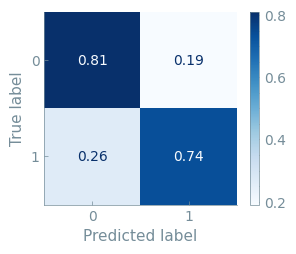

In [10]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]
confusion_matrix_max = []
for index, _ in enumerate(conf_mats_max):
    try:
        preds = conf_mats_max[index]
        actual = preds["all_y_true"]
        predicted = preds["all_y_pred"]
        confusion_matrix = metrics.confusion_matrix(actual, predicted)
        confusion_matrix_max.append(confusion_matrix)
    except Exception as e:
        print(e)
norm_confusion_matrix = sum(confusion_matrix_max)/[[sum(sum(confusion_matrix_max)[0])], [sum(sum(confusion_matrix_max)[1])]]
print(norm_confusion_matrix)

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = norm_confusion_matrix, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.savefig('classif_H2CO_confusionMatrix_50_50_100ep_size45.pdf', bbox_inches='tight')

In [11]:
sizes = np.sort(compiled_res["train_size"].unique())
print(sizes)

[ 5 10 15 20 25 30 35 40 45]


In [12]:
print(grouped_res.loc[sizes, :]['accuracy'])

                mean       sem
train_size                    
5           0.566667  0.018812
10          0.595000  0.031136
15          0.680000  0.030949
20          0.650000  0.021228
25          0.755556  0.012373
30          0.710000  0.027689
35          0.783333  0.020893
40          0.740000  0.030551
45          0.775000  0.059010


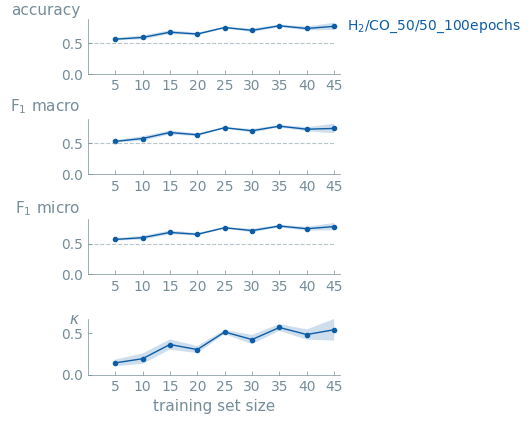

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

n_bins = 2
representations = ['50/50_100epochs']

for representation in representations:
    ax[0].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['accuracy']['mean'],
        marker='o',
        label=f'H$_2$/CO_{representation}'
    )
    ax[0].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['accuracy']['mean']
        -grouped_res.loc[sizes, :]['accuracy']['sem'],
        grouped_res.loc[sizes, :]['accuracy']['mean']
        +grouped_res.loc[sizes, :]['accuracy']['sem'],
        alpha = 0.2
    )
    
    ax[0].hlines(0.5, 0, 45, linestyle='--', color='#758D99', alpha=0.5, linewidth=0.8)
    ylabel_top('accuracy', ax=ax[0])
    ax[0].set_xticks(sizes)
    ax[0].set_xlim(0, 46)
    ax[0].set_ylim(0, 0.9)

    ax[1].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_macro']['mean'],
        marker='o',
        label=f'{representation}'
    )
    ax[1].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_macro']['mean']
        -grouped_res.loc[sizes, :]['f1_macro']['sem'],
        grouped_res.loc[sizes, :]['f1_macro']['mean']
        +grouped_res.loc[sizes, :]['f1_macro']['sem'],
        alpha=0.2
    )

    ax[1].hlines(0.5, 0, 45, linestyle='--', color='#758D99', alpha=0.5, linewidth=0.8)
    ylabel_top(r'F$_1$ macro', ax=ax[1])
    ax[1].set_xticks(sizes)
    ax[1].set_xlim(0, 46)
    ax[1].set_ylim(0, 0.9)

    ax[2].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_micro']['mean'],
        marker='o',
        label=f'{representation}'
    )

    ax[2].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_micro']['mean']
        -grouped_res.loc[sizes, :]['f1_micro']['sem'],
        grouped_res.loc[sizes, :]['f1_micro']['mean']
        +grouped_res.loc[sizes, :]['f1_micro']['sem'],
        alpha=0.2
    )

    ax[2].hlines(0.5, 0, 45, linestyle='--', color='#758D99', alpha=0.5, linewidth=0.8)
    ylabel_top(r'F$_1$ micro', ax=ax[2])
    ax[2].set_xticks(sizes)
    ax[2].set_xlim(0, 46)
    ax[2].set_ylim(0, 0.9)

    ax[3].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['kappa']['mean'],
        marker='o',
        label=f'{representation}'
    )
    ax[3].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['kappa']['mean']
        -grouped_res.loc[sizes, :]['kappa']['sem'],
        grouped_res.loc[sizes, :]['kappa']['mean']
        +grouped_res.loc[sizes, :]['kappa']['sem'],
        alpha=0.2
    )
    
    ax[3].hlines(0, 0, 0, linestyle='--', color='#758D99', alpha=0.5, linewidth=0.8)
    #ax[3].hlines(-0.1, 0, 0, linestyle='--', color='#758D99', alpha=0.5)
    ylabel_top(r'$\kappa$', ax=ax[3])
    ax[3].set_xticks(sizes)
    ax[3].set_xlim(0, 46)

ax[-1].set_xlabel('training set size')

matplotx.line_labels(ax[0])
plt.subplots_adjust(hspace=0.8, top=1, bottom=0.2)
fig.savefig('classif_H2COgasif_50_50_100ep_size45.pdf', bbox_inches='tight')